✅ Portfolio loaded successfully with 39 stocks.
       Symbol  Quantity  Closing Price  MarketValue    Weight
0         ACC        12        1850.10      22201.2  0.043625
1  ADANIPORTS        14        1429.00      20006.0  0.039312
2  ADANIPOWER        50         167.72       8386.0  0.016479
3   AMBUJACEM        20         555.00      11100.0  0.021812
4  BAJAJHLDNG         3       13144.00      39432.0  0.077484


[*********************100%***********************]  39 of 39 completed
C:\Users\sharad sharma\AppData\Local\Temp\ipykernel_27300\3322940643.py:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()


✅ Data downloaded for 39 stocks.

🟢 Global Minimum Variance Portfolio:
Return: 9.71%, Volatility: 11.49%

🟡 Maximum Sharpe Ratio Portfolio:
Return: 32.56%, Volatility: 17.56%, Sharpe: 1.484


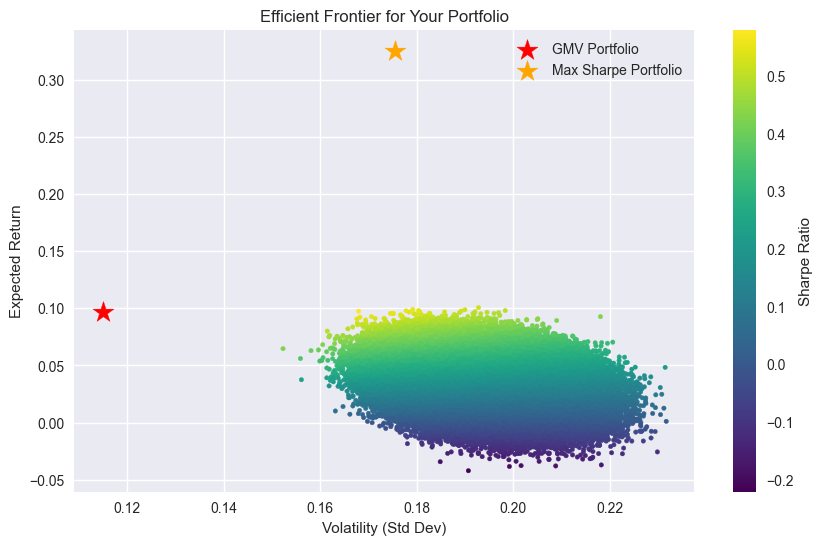

In [43]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ========== STEP 1: Load your portfolio ==========
file_path = r"C:\Users\sharad sharma\OneDrive\Desktop\Credit Risk\Risk_Xplore\Session 5\Stocks_Holdings_Statement_8729407035_2025-10-26.xlsx"

df = pd.read_excel(file_path, skiprows=10, nrows=40)
df = df.iloc[:, 2:]
df = df[['SYMBOL', 'Quantity', 'Closing price']]
df.columns = ['Symbol', 'Quantity', 'Closing Price']

# Calculate Market Value and Weights
df['MarketValue'] = df['Quantity'] * df['Closing Price']
df['Weight'] = df['MarketValue'] / df['MarketValue'].sum()

print("✅ Portfolio loaded successfully with", len(df), "stocks.")
print(df.head())

# ========== STEP 2: Download price data ==========
symbols = [s.strip() + ".NS" for s in df['Symbol']]
data = yf.download(symbols, start="2010-01-01", end="2025-10-26", auto_adjust=True)
data = data['Close'].dropna(axis=1, how='all')

# Ensure only stocks with data remain
valid_symbols = data.columns.tolist()
df = df[df['Symbol'].isin([s.replace(".NS", "") for s in valid_symbols])]
symbols = [s.strip() + ".NS" for s in df['Symbol']]

print("✅ Data downloaded for", len(symbols), "stocks.")

# ========== STEP 3: Calculate returns ==========
daily_returns = data.pct_change().dropna()
mean_daily_returns = daily_returns.mean()
annual_returns = mean_daily_returns * 252
cov_matrix_annual = daily_returns.cov() * 252

# ========== STEP 4: Generate random portfolios ==========
num_portfolios = 1000000
num_stocks = len(symbols)

weights = np.random.rand(num_portfolios, num_stocks)
weights = weights / weights.sum(axis=1)[:, np.newaxis]

portfolio_returns = np.dot(weights, annual_returns)
portfolio_variance = np.einsum('ij,jk,ik->i', weights, cov_matrix_annual, weights)
portfolio_risk = np.sqrt(portfolio_variance)
sharpe_ratio = portfolio_returns / portfolio_risk

# Combine results
portfolios = pd.DataFrame({
    'Return': portfolio_returns,
    'Volatility': portfolio_risk,
    'Sharpe': sharpe_ratio
})

# ========== STEP 5: Optimize for GMV & Max Sharpe ==========
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.065):
    p_ret = np.dot(weights, mean_returns)
    p_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(p_ret - risk_free_rate) / p_std

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = tuple((0, 1) for _ in range(num_stocks))
init_guess = np.array(num_stocks * [1. / num_stocks])

# ----- GMV -----
opt_gmv = minimize(portfolio_volatility, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
gmv_weights = opt_gmv.x
gmv_return = np.dot(gmv_weights, annual_returns)
gmv_risk = portfolio_volatility(gmv_weights, cov_matrix_annual)

# ----- Max Sharpe -----
opt_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(annual_returns, cov_matrix_annual, 0.065),
                      method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = opt_sharpe.x
max_sharpe_return = np.dot(max_sharpe_weights, annual_returns)
max_sharpe_risk = portfolio_volatility(max_sharpe_weights, cov_matrix_annual)
max_sharpe_value = (max_sharpe_return - 0.065) / max_sharpe_risk

# ========== STEP 6: Display Results ==========
print("\n🟢 Global Minimum Variance Portfolio:")
print(f"Return: {gmv_return*100:.2f}%, Volatility: {gmv_risk*100:.2f}%")

print("\n🟡 Maximum Sharpe Ratio Portfolio:")
print(f"Return: {max_sharpe_return*100:.2f}%, Volatility: {max_sharpe_risk*100:.2f}%, Sharpe: {max_sharpe_value:.3f}")

gmv_portfolio = pd.DataFrame({'Stock': [s.replace(".NS","") for s in symbols], 'Weight': gmv_weights})
sharpe_portfolio = pd.DataFrame({'Stock': [s.replace(".NS","") for s in symbols], 'Weight': max_sharpe_weights})

# ========== STEP 7: Plot Efficient Frontier ==========
plt.figure(figsize=(10,6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(gmv_risk, gmv_return, color='red', marker='*', s=250, label='GMV Portfolio')
plt.scatter(max_sharpe_risk, max_sharpe_return, color='orange', marker='*', s=250, label='Max Sharpe Portfolio')
plt.title('Efficient Frontier for Your Portfolio')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


✅ Portfolio Holdings:
        Symbol  Quantity  Closing Price  MarketValue    Weight
0         ACC        12        1850.10      22201.2  0.043625
1  ADANIPORTS        14        1429.00      20006.0  0.039312
2  ADANIPOWER        50         167.72       8386.0  0.016479
3   AMBUJACEM        20         555.00      11100.0  0.021812
4  BAJAJHLDNG         3       13144.00      39432.0  0.077484


C:\Users\sharad sharma\AppData\Local\Temp\ipykernel_27300\1166978363.py:46: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()


✅ Data downloaded for 39 stocks.

✅ Annualized Returns and Volatility calculated.

📊 Portfolio Performance (Based on Actual Weights)
Expected Annual Return: 8.31%
Annualized Volatility : 19.80%

✅ Monte Carlo simulation completed.

🌿 Global Minimum Variance Portfolio
Expected Annual Return : 9.71%
Annualized Risk (Std)  : 11.49%

🚀 Maximum Sharpe Ratio Portfolio
Expected Annual Return : 32.56%
Annualized Risk (Std)  : 17.56%
Sharpe Ratio           : 1.48


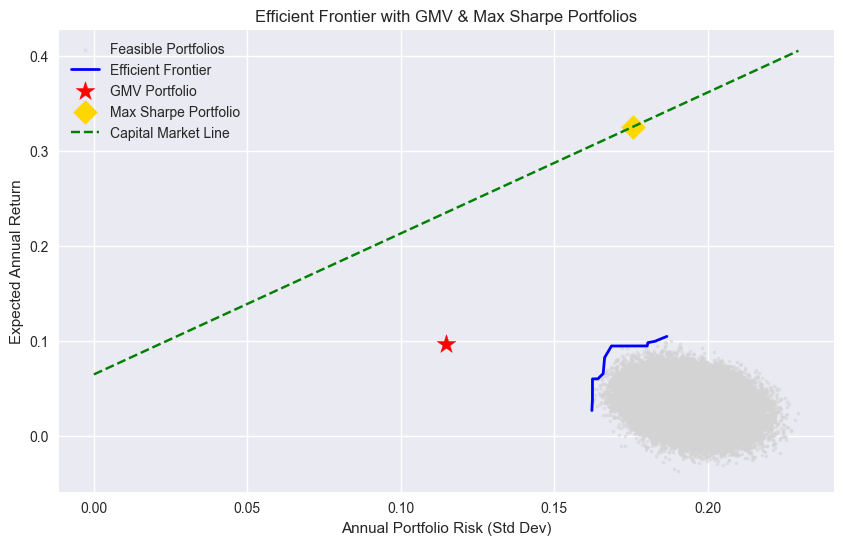


📘 Portfolio Validation & Summary Report
--------------------------------------------------
GMV Portfolio - Expected Return : 9.71% | Risk : 11.49%
Max Sharpe Portfolio - Return : 32.56% | Risk : 17.56% | Sharpe : 1.48
Actual Portfolio - Return : 8.31% | Risk : 19.80%

✅ Final Portfolio Summary Table:
   Portfolio Type  Expected Return (%)  Annual Risk (%)  Sharpe Ratio
0          Actual                8.314           19.800         0.092
1  Global Min Var                9.708           11.485         0.279
2      Max Sharpe               32.556           17.557         1.484

💾 Results saved to 'Portfolio_Optimization_Summary.xlsx'


In [44]:
# ======================================================
# 🔹 Portfolio Optimization (Clean Final Version)
# ======================================================

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ======================================================
# 1️⃣ Data Import & Cleaning
# ======================================================

file_path = r"C:\Users\sharad sharma\OneDrive\Desktop\Credit Risk\Risk_Xplore\Session 5\Stocks_Holdings_Statement_8729407035_2025-10-26.xlsx"

df = pd.read_excel(file_path, skiprows=10, nrows=40)
df = df.iloc[:, 2:]
df = df[['SYMBOL', 'Quantity', 'Closing price']]
df.columns = ['Symbol', 'Quantity', 'Closing Price']

# Calculate market value & weights
df['MarketValue'] = df['Quantity'] * df['Closing Price']
df['Weight'] = df['MarketValue'] / df['MarketValue'].sum()

print("✅ Portfolio Holdings:\n", df.head())

# ======================================================
# 2️⃣ Fetch Historical Data from Yahoo Finance
# ======================================================

symbols = [s.strip() + ".NS" for s in df['Symbol']]

data = yf.download(
    symbols,
    start="2010-10-01",
    end="2025-10-26",
    auto_adjust=True,
    progress=False
)

# Keep only close prices
data = data['Close'].dropna(axis=1, how='all')

# Calculate daily returns
daily_returns = data.pct_change().dropna()

print(f"✅ Data downloaded for {data.shape[1]} stocks.")

# ======================================================
# 3️⃣ Compute Mean Returns & Risk Metrics
# ======================================================

mean_daily_returns = daily_returns.mean()
annual_returns = mean_daily_returns * 252
daily_std = daily_returns.std()
annual_std = daily_std * np.sqrt(252)

cov_matrix_daily = daily_returns.cov()
cov_matrix_annual = cov_matrix_daily * 252

print("\n✅ Annualized Returns and Volatility calculated.")

# ======================================================
# 4️⃣ Portfolio Expected Return & Risk (Given Weights)
# ======================================================

weights = np.array(df['Weight'])
weights /= np.sum(weights)

portfolio_return = np.dot(weights, annual_returns)
portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

print("\n📊 Portfolio Performance (Based on Actual Weights)")
print(f"Expected Annual Return: {portfolio_return*100:.2f}%")
print(f"Annualized Volatility : {portfolio_std*100:.2f}%")

# ======================================================
# 5️⃣ Monte Carlo Simulation for Feasible Portfolios
# ======================================================

num_portfolios = 200000
num_stocks = len(daily_returns.columns)

random_weights = np.random.rand(num_portfolios, num_stocks)
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

portfolio_returns = np.dot(random_weights, annual_returns)
portfolio_variance = np.einsum('ij,jk,ik->i', random_weights, cov_matrix_annual, random_weights)
portfolio_risk = np.sqrt(portfolio_variance)

portfolios = pd.DataFrame({
    'Annual Portfolio Return': portfolio_returns,
    'Annual Portfolio Risk': portfolio_risk
})

print("\n✅ Monte Carlo simulation completed.")

# ======================================================
# 6️⃣ Global Minimum Variance (GMV) Portfolio
# ======================================================

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = tuple((0, 1) for _ in range(num_stocks))
init_guess = np.repeat(1/num_stocks, num_stocks)

gmv_result = minimize(
    portfolio_volatility,
    init_guess,
    args=(cov_matrix_annual,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

gmv_weights = gmv_result.x
gmv_return = np.dot(gmv_weights, annual_returns)
gmv_risk = portfolio_volatility(gmv_weights, cov_matrix_annual)

print("\n🌿 Global Minimum Variance Portfolio")
print(f"Expected Annual Return : {gmv_return*100:.2f}%")
print(f"Annualized Risk (Std)  : {gmv_risk*100:.2f}%")

# ======================================================
# 7️⃣ Maximum Sharpe Ratio Portfolio
# ======================================================

risk_free_rate = 0.065  # 6.5% risk-free rate

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_ret = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_ret - rf) / port_std

opt_sharpe = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(annual_returns, cov_matrix_annual, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

sharpe_weights = opt_sharpe.x
sharpe_return = np.dot(sharpe_weights, annual_returns)
sharpe_risk = portfolio_volatility(sharpe_weights, cov_matrix_annual)
max_sharpe = (sharpe_return - risk_free_rate) / sharpe_risk

print("\n🚀 Maximum Sharpe Ratio Portfolio")
print(f"Expected Annual Return : {sharpe_return*100:.2f}%")
print(f"Annualized Risk (Std)  : {sharpe_risk*100:.2f}%")
print(f"Sharpe Ratio           : {max_sharpe:.2f}")

# ======================================================
# 8️⃣ Efficient Frontier + Capital Allocation Line
# ======================================================

portfolios_sorted = portfolios.sort_values(by='Annual Portfolio Risk')
efficient_frontier = portfolios_sorted[
    portfolios_sorted['Annual Portfolio Return'].cummax() == portfolios_sorted['Annual Portfolio Return']
]

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Annual Portfolio Risk'], portfolios['Annual Portfolio Return'],
            c='lightgray', alpha=0.5, s=5, label='Feasible Portfolios')

plt.plot(efficient_frontier['Annual Portfolio Risk'], efficient_frontier['Annual Portfolio Return'],
         color='blue', linewidth=2, label='Efficient Frontier')

plt.scatter(gmv_risk, gmv_return, color='red', marker='*', s=200, label='GMV Portfolio')
plt.scatter(sharpe_risk, sharpe_return, color='gold', marker='D', s=150, label='Max Sharpe Portfolio')

# Capital Market Line (CML)
x = np.linspace(0, portfolios['Annual Portfolio Risk'].max(), 100)
cml = risk_free_rate + max_sharpe * x
plt.plot(x, cml, color='green', linestyle='--', label='Capital Market Line')

plt.xlabel('Annual Portfolio Risk (Std Dev)')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier with GMV & Max Sharpe Portfolios')
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# 9️⃣ Portfolio Validation & Reporting Block (FINAL)
# ======================================================

print("\n📘 Portfolio Validation & Summary Report")
print("-" * 50)
print(f"GMV Portfolio - Expected Return : {gmv_return*100:.2f}% | Risk : {gmv_risk*100:.2f}%")
print(f"Max Sharpe Portfolio - Return : {sharpe_return*100:.2f}% | Risk : {sharpe_risk*100:.2f}% | Sharpe : {max_sharpe:.2f}")
print(f"Actual Portfolio - Return : {portfolio_return*100:.2f}% | Risk : {portfolio_std*100:.2f}%")

summary = pd.DataFrame({
    'Portfolio Type': ['Actual', 'Global Min Var', 'Max Sharpe'],
    'Expected Return (%)': [portfolio_return*100, gmv_return*100, sharpe_return*100],
    'Annual Risk (%)': [portfolio_std*100, gmv_risk*100, sharpe_risk*100],
    'Sharpe Ratio': [
        (portfolio_return - risk_free_rate) / portfolio_std,
        (gmv_return - risk_free_rate) / gmv_risk,
        max_sharpe
    ]
}).round(3)

print("\n✅ Final Portfolio Summary Table:")
print(summary)

# Save for reporting
summary.to_excel("Portfolio_Optimization_Summary.xlsx", index=False)
print("\n💾 Results saved to 'Portfolio_Optimization_Summary.xlsx'")


In [45]:
# ======================================================
# 🧩 Tabular Comparison of Portfolio Weights
# ======================================================

# Create DataFrame comparing weights
comparison_df = pd.DataFrame({
    'Symbol': [s.replace(".NS", "") for s in common_stocks],
    'Actual Weight': weights,
    'GMV Weight': gmv_weights,
    'Max Sharpe Weight': sharpe_weights
})

# Calculate portfolio-level metrics
portfolio_metrics = pd.DataFrame({
    'Portfolio': ['Actual', 'Global Min Variance', 'Max Sharpe'],
    'Expected Annual Return (%)': [
        portfolio_return * 100, gmv_return * 100, sharpe_return * 100
    ],
    'Annual Risk (Std) (%)': [
        portfolio_std * 100, gmv_risk * 100, sharpe_risk * 100
    ],
    'Sharpe Ratio': [
        (portfolio_return - risk_free_rate) / portfolio_std,
        (gmv_return - risk_free_rate) / gmv_risk,
        (sharpe_return - risk_free_rate) / sharpe_risk
    ]
}).round(4)

# Export both to Excel (optional)
with pd.ExcelWriter("Portfolio_Comparison_Report.xlsx") as writer:
    comparison_df.to_excel(writer, sheet_name="Weights Comparison", index=False)
    portfolio_metrics.to_excel(writer, sheet_name="Portfolio Metrics", index=False)

# Display top results in console
print("\n📘 Portfolio Weights Comparison (top 10 stocks by GMV weight):")
print(comparison_df.sort_values(by='GMV Weight', ascending=False).head(10))

print("\n📈 Portfolio Performance Metrics:")
print(portfolio_metrics)



📘 Portfolio Weights Comparison (top 10 stocks by GMV weight):
        Symbol  Actual Weight  GMV Weight  Max Sharpe Weight
15    HDFCBANK       0.164194    0.220129           0.236341
17  HINDUNILVR       0.014834    0.199729           0.000000
35   TATAPOWER       0.003119    0.159585           0.000000
20         ITC       0.008190    0.130854           0.000000
6   BERGEPAINT       0.015011    0.097710           0.000000
7   BHARTIARTL       0.011963    0.053459           0.482516
14     HAVELLS       0.017625    0.041732           0.000000
5    BANKINDIA       0.018418    0.037433           0.000000
38    UNITDSPR       0.021338    0.031273           0.000000
10       DABUR       0.004996    0.010078           0.000000

📈 Portfolio Performance Metrics:
             Portfolio  Expected Annual Return (%)  Annual Risk (Std) (%)  \
0               Actual                      8.3141                19.8003   
1  Global Min Variance                      9.7082                11.4853   
2

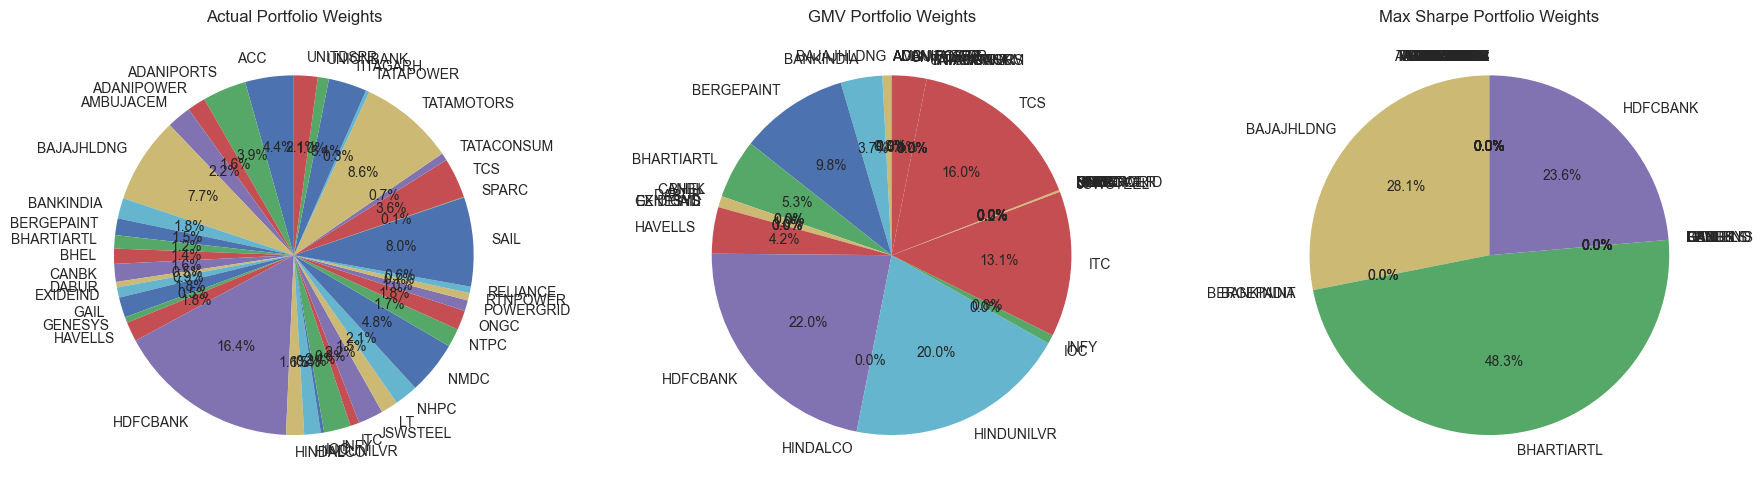


📊 Visualization Complete — All Outputs Generated Successfully!


In [50]:
# 🔟 Pie Charts for Portfolio Composition
# ======================================================

labels = [s.replace(".NS", "") for s in common_stocks]

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pie(weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Actual Portfolio Weights")

plt.subplot(1, 3, 2)
plt.pie(gmv_weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("GMV Portfolio Weights")

plt.subplot(1, 3, 3)
plt.pie(sharpe_weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Max Sharpe Portfolio Weights")

plt.tight_layout()
plt.show()

print("\n📊 Visualization Complete — All Outputs Generated Successfully!")

✅ Portfolio Holdings:
        Symbol  Quantity  Closing Price  MarketValue    Weight
0         ACC        12        1850.10      22201.2  0.043625
1  ADANIPORTS        14        1429.00      20006.0  0.039312
2  ADANIPOWER        50         167.72       8386.0  0.016479
3   AMBUJACEM        20         555.00      11100.0  0.021812
4  BAJAJHLDNG         3       13144.00      39432.0  0.077484


C:\Users\sharad sharma\AppData\Local\Temp\ipykernel_27300\1594810561.py:46: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()


✅ Data downloaded for 39 valid stocks.

✅ Annualized Returns and Volatility calculated.

📊 Portfolio Performance (Based on Actual Weights)
Expected Annual Return: 4.25%
Annualized Volatility : 19.27%

✅ Monte Carlo simulation completed.

🌿 Global Minimum Variance Portfolio
Expected Annual Return : 9.71%
Annualized Risk (Std)  : 11.49%

🚀 Maximum Sharpe Ratio Portfolio
Expected Annual Return : 32.56%
Annualized Risk (Std)  : 17.56%
Sharpe Ratio           : 1.48


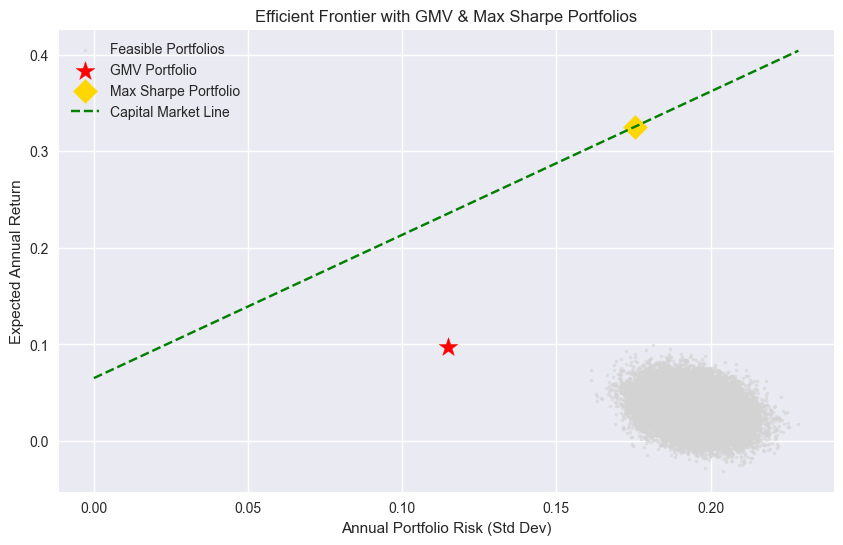


✅ Final Portfolio Summary:
   Portfolio Type  Expected Return (%)  Annual Risk (%)  Sharpe Ratio
0          Actual                4.246           19.270        -0.117
1  Global Min Var                9.708           11.485         0.279
2      Max Sharpe               32.556           17.557         1.484


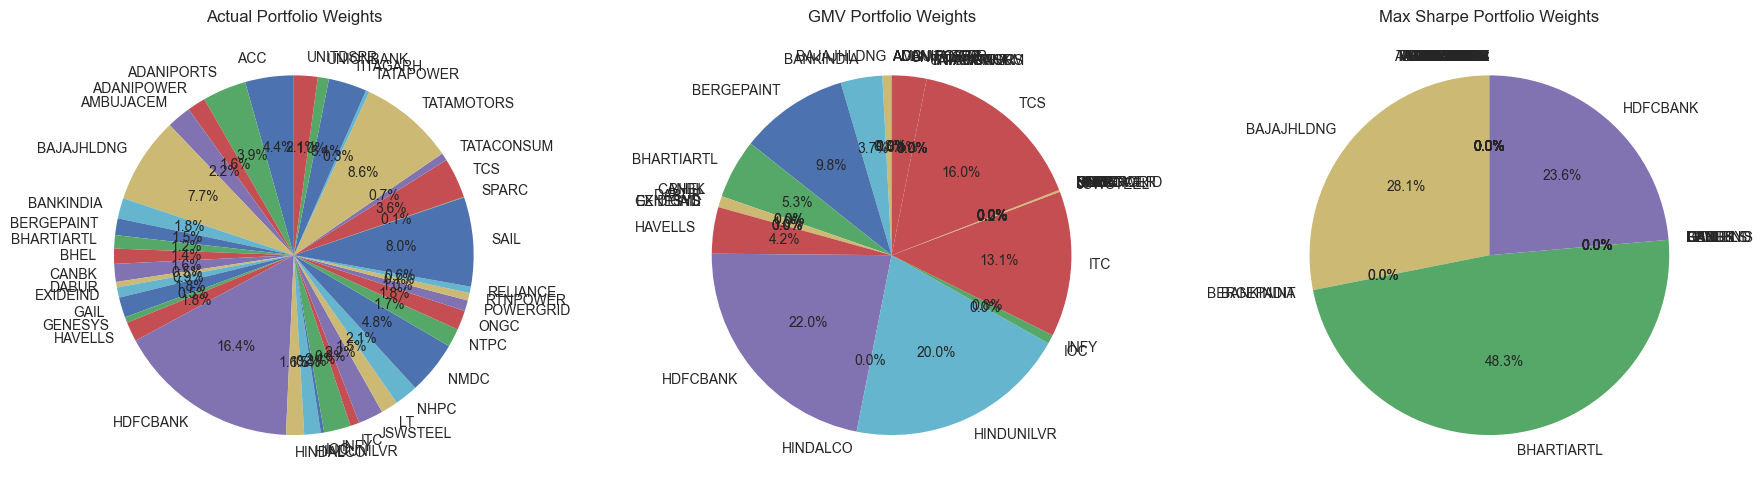


📊 Visualization Complete — All Outputs Generated Successfully!


In [46]:
# ======================================================
# 🔹 Portfolio Optimization (Final + Visualization)
# ======================================================

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ======================================================
# 1️⃣ Data Import & Cleaning
# ======================================================

file_path = r"C:\Users\sharad sharma\OneDrive\Desktop\Credit Risk\Risk_Xplore\Session 5\Stocks_Holdings_Statement_8729407035_2025-10-26.xlsx"

df = pd.read_excel(file_path, skiprows=10, nrows=40)
df = df.iloc[:, 2:]
df = df[['SYMBOL', 'Quantity', 'Closing price']]
df.columns = ['Symbol', 'Quantity', 'Closing Price']

# Calculate market value & weights
df['MarketValue'] = df['Quantity'] * df['Closing Price']
df['Weight'] = df['MarketValue'] / df['MarketValue'].sum()

print("✅ Portfolio Holdings:\n", df.head())

# ======================================================
# 2️⃣ Fetch Historical Data from Yahoo Finance
# ======================================================

symbols = [s.strip() + ".NS" for s in df['Symbol']]

data = yf.download(
    symbols,
    start="2015-01-01",
    end="2025-10-26",
    auto_adjust=True,
    progress=False
)

# Keep only close prices
data = data['Close'].dropna(axis=1, how='all')

# Calculate daily returns
daily_returns = data.pct_change().dropna()

print(f"✅ Data downloaded for {data.shape[1]} valid stocks.")

# ======================================================
# 3️⃣ Compute Mean Returns & Risk Metrics
# ======================================================

mean_daily_returns = daily_returns.mean()
annual_returns = mean_daily_returns * 252
daily_std = daily_returns.std()
annual_std = daily_std * np.sqrt(252)

cov_matrix_daily = daily_returns.cov()
cov_matrix_annual = cov_matrix_daily * 252

print("\n✅ Annualized Returns and Volatility calculated.")

# ======================================================
# 4️⃣ Portfolio Expected Return & Risk (Given Weights)
# ======================================================

# Align portfolio with available stocks
common_stocks = [s for s in symbols if s in data.columns]
df = df[df['Symbol'].apply(lambda x: x + ".NS" in common_stocks)]

weights = np.array(df['Weight'])
weights /= np.sum(weights)

annual_returns = annual_returns.loc[common_stocks]
cov_matrix_annual = cov_matrix_annual.loc[common_stocks, common_stocks]

portfolio_return = np.dot(weights, annual_returns)
portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

print("\n📊 Portfolio Performance (Based on Actual Weights)")
print(f"Expected Annual Return: {portfolio_return*100:.2f}%")
print(f"Annualized Volatility : {portfolio_std*100:.2f}%")

# ======================================================
# 5️⃣ Monte Carlo Simulation for Feasible Portfolios
# ======================================================

num_portfolios = 50000
num_stocks = len(common_stocks)

random_weights = np.random.rand(num_portfolios, num_stocks)
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

portfolio_returns = np.dot(random_weights, annual_returns)
portfolio_variance = np.einsum('ij,jk,ik->i', random_weights, cov_matrix_annual, random_weights)
portfolio_risk = np.sqrt(portfolio_variance)

portfolios = pd.DataFrame({
    'Annual Portfolio Return': portfolio_returns,
    'Annual Portfolio Risk': portfolio_risk
})

print("\n✅ Monte Carlo simulation completed.")

# ======================================================
# 6️⃣ Global Minimum Variance (GMV) Portfolio
# ======================================================

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = tuple((0, 1) for _ in range(num_stocks))
init_guess = np.repeat(1/num_stocks, num_stocks)

gmv_result = minimize(
    portfolio_volatility,
    init_guess,
    args=(cov_matrix_annual,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

gmv_weights = gmv_result.x
gmv_return = np.dot(gmv_weights, annual_returns)
gmv_risk = portfolio_volatility(gmv_weights, cov_matrix_annual)

print("\n🌿 Global Minimum Variance Portfolio")
print(f"Expected Annual Return : {gmv_return*100:.2f}%")
print(f"Annualized Risk (Std)  : {gmv_risk*100:.2f}%")

# ======================================================
# 7️⃣ Maximum Sharpe Ratio Portfolio
# ======================================================

risk_free_rate = 0.065  # 6.5%

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_ret = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_ret - rf) / port_std

opt_sharpe = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(annual_returns, cov_matrix_annual, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

sharpe_weights = opt_sharpe.x
sharpe_return = np.dot(sharpe_weights, annual_returns)
sharpe_risk = portfolio_volatility(sharpe_weights, cov_matrix_annual)
max_sharpe = (sharpe_return - risk_free_rate) / sharpe_risk

print("\n🚀 Maximum Sharpe Ratio Portfolio")
print(f"Expected Annual Return : {sharpe_return*100:.2f}%")
print(f"Annualized Risk (Std)  : {sharpe_risk*100:.2f}%")
print(f"Sharpe Ratio           : {max_sharpe:.2f}")

# ======================================================
# 8️⃣ Efficient Frontier + Capital Market Line
# ======================================================

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Annual Portfolio Risk'], portfolios['Annual Portfolio Return'],
            c='lightgray', alpha=0.5, s=5, label='Feasible Portfolios')

plt.scatter(gmv_risk, gmv_return, color='red', marker='*', s=200, label='GMV Portfolio')
plt.scatter(sharpe_risk, sharpe_return, color='gold', marker='D', s=150, label='Max Sharpe Portfolio')

x = np.linspace(0, portfolios['Annual Portfolio Risk'].max(), 100)
cml = risk_free_rate + max_sharpe * x
plt.plot(x, cml, color='green', linestyle='--', label='Capital Market Line')

plt.xlabel('Annual Portfolio Risk (Std Dev)')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier with GMV & Max Sharpe Portfolios')
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# 9️⃣ Portfolio Validation & Reporting
# ======================================================

summary = pd.DataFrame({
    'Portfolio Type': ['Actual', 'Global Min Var', 'Max Sharpe'],
    'Expected Return (%)': [portfolio_return*100, gmv_return*100, sharpe_return*100],
    'Annual Risk (%)': [portfolio_std*100, gmv_risk*100, sharpe_risk*100],
    'Sharpe Ratio': [
        (portfolio_return - risk_free_rate) / portfolio_std,
        (gmv_return - risk_free_rate) / gmv_risk,
        max_sharpe
    ]
}).round(3)

summary.to_excel("Portfolio_Optimization_Summary.xlsx", index=False)

print("\n✅ Final Portfolio Summary:")
print(summary)

# ======================================================
# 🔟 Pie Charts for Portfolio Composition
# ======================================================

labels = [s.replace(".NS", "") for s in common_stocks]

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pie(weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Actual Portfolio Weights")

plt.subplot(1, 3, 2)
plt.pie(gmv_weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("GMV Portfolio Weights")

plt.subplot(1, 3, 3)
plt.pie(sharpe_weights, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Max Sharpe Portfolio Weights")

plt.tight_layout()
plt.show()

print("\n📊 Visualization Complete — All Outputs Generated Successfully!")


In [47]:
# ======================================================
# 🧩 Tabular Comparison of Portfolio Weights
# ======================================================

# Create DataFrame comparing weights
comparison_df = pd.DataFrame({
    'Symbol': [s.replace(".NS", "") for s in common_stocks],
    'Actual Weight': weights,
    'GMV Weight': gmv_weights,
    'Max Sharpe Weight': sharpe_weights
})

# Calculate portfolio-level metrics
portfolio_metrics = pd.DataFrame({
    'Portfolio': ['Actual', 'Global Min Variance', 'Max Sharpe'],
    'Expected Annual Return (%)': [
        portfolio_return * 100, gmv_return * 100, sharpe_return * 100
    ],
    'Annual Risk (Std) (%)': [
        portfolio_std * 100, gmv_risk * 100, sharpe_risk * 100
    ],
    'Sharpe Ratio': [
        (portfolio_return - risk_free_rate) / portfolio_std,
        (gmv_return - risk_free_rate) / gmv_risk,
        (sharpe_return - risk_free_rate) / sharpe_risk
    ]
}).round(4)

# Export both to Excel (optional)
with pd.ExcelWriter("Portfolio_Comparison_Report.xlsx") as writer:
    comparison_df.to_excel(writer, sheet_name="Weights Comparison", index=False)
    portfolio_metrics.to_excel(writer, sheet_name="Portfolio Metrics", index=False)

# Display top results in console
print("\n📘 Portfolio Weights Comparison (top 10 stocks by GMV weight):")
print(comparison_df.sort_values(by='GMV Weight', ascending=False).head(10))

print("\n📈 Portfolio Performance Metrics:")
print(portfolio_metrics)



📘 Portfolio Weights Comparison (top 10 stocks by GMV weight):
        Symbol  Actual Weight  GMV Weight  Max Sharpe Weight
15    HDFCBANK       0.164194    0.220128       2.363404e-01
17  HINDUNILVR       0.014834    0.199729       1.796302e-15
32         TCS       0.036115    0.159585       0.000000e+00
20         ITC       0.008190    0.130854       6.229844e-16
6   BERGEPAINT       0.015011    0.097710       1.305610e-15
7   BHARTIARTL       0.011963    0.053459       4.825159e-01
14     HAVELLS       0.017625    0.041732       2.188530e-16
5    BANKINDIA       0.018418    0.037433       1.744278e-15
38    UNITDSPR       0.021338    0.031273       1.065564e-15
10       DABUR       0.004996    0.010078       1.218569e-15

📈 Portfolio Performance Metrics:
             Portfolio  Expected Annual Return (%)  Annual Risk (Std) (%)  \
0               Actual                      4.2461                19.2703   
1  Global Min Variance                      9.7082                11.4853   
2